## TestModelOverClusters_ControlledForSampleSize

This script evaluates how predictive performance varies with sample size and number of clusters, while controlling for unequal image counts across clusters.

*Data*  
- Reads in a pickle files which contains a dataframe with one row per sampled image. Each image is associated with a location (lat, lon), a link to the image_file, an embedding, category_scores, and the cluster the image has been assigned to with both 2 and 7 total clusters
- Reads in IMD data (for use in model fitting)

*Subsampling*  
Rather than constructing fixed subsample dictionaries in advance, subsampling is performed dynamically during model fitting.  
For each value of k:
- The dataframe is grouped by the corresponding cluster label (scene_cluster_k).
- For each requested sample size [500,1000,2000,3000,4000,5000,6000,7000,10000,12500,15000,20000]:
    - Up to N images are randomly sampled from each cluster independently.
    - If a cluster contains fewer than N images, all available images are used (i.e. the sample is capped).
    - The effective number of samples per cluster is recorded for later diagnostics.

This subsampling procedure is repeated multiple times using different random seeds in order to capture sampling variability.

*Feature construction*  
For each subsampled dataset:
- Images are grouped by LSOA.
- Within each LSOA and cluster, embeddings are averaged to produce a mean cluster embedding per LSOA.
- These per-cluster mean embeddings are merged into a single modelling table.
- IMD rank is joined and re-ranked to produce a continuous prediction target.

Model fitting

For each combination of:
- number of clusters k
- subsample size N
- random repeat
- individual cluster within k

the following procedure is applied:
- If a cluster was capped (i.e. contains fewer than N images), model fitting for that cluster is skipped.
- LSOAs with missing embeddings are removed.
- A random train–test split (80/20) is applied.
- An XGBoost model is trained to predict IMD rank using only the mean embedding from the given cluster.

In [33]:
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold

from joblib import Parallel, delayed
from sklearn.base import clone
import joblib

def is_missing_embedding(x):
    return isinstance(x, float) and np.isnan(x)

# Aggregation functions
def mean_embed(series):
    return np.mean(np.stack(series.values), axis=0)

from functions import *

In [2]:
data_dir = os.path.join("../../../../data/embeddings/")

In [3]:
k=7

In [34]:
best_model = joblib.load(os.path.join(data_dir, "5-imd_best_model_bundle.joblib"))['model']
model = clone(best_model)

Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.


In [ ]:
# Specify the size of subsamples we wish to make
sample_sizes = [500,1000,2000,3000,4000,5000,6000,7000,10000,12500,15000,20000]

### Get data

In [4]:
points_data_cache = data_dir + f"embeddings/one_row_per_image_cleaned_with_cluster_numbers.pkl"
with open(points_data_cache, "rb") as f:
    expanded_gdf = pickle.load(f)

In [5]:
# for num in range(1,8):
#     print(num)
#     print(len(expanded_gdf[expanded_gdf['scene_cluster_7']==num]))

In [6]:
# final_df = final_df.merge(lsoa_summary, on = "LSOA21CD")
# file_ending = f'kmeanscluster{k}_resampled1'
# final_df.to_pickle(data_dir + f"embedding_summaries/big_summary_df_{file_ending}.pkl")

### Read in IMD data

In [7]:
imd_file = os.path.join("../../../../", "data", "imd", "File_2_-_IoD2025_Domains_of_Deprivation.xlsx")
imd = pd.read_excel(imd_file, sheet_name="IoD2025 Domains", header=0)

# Rename columns to simpler versions
imd_col_map = {"LSOA code (2021)": "LSOA21CD",
    "Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)": "imd_rank",
    "Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)": "imd_decile"}
imd = imd.rename(columns=imd_col_map)

# Test model performance 


In [35]:
# Function to 
def sub_sample_data(df, cluster_col, n_per_cluster, random_state=None):
    """
    Take a sample from a dataframe by sampling up to
    n_per_cluster rows from each cluster.

    If a cluster has fewer than n_per_cluster rows, all rows
    from that cluster are used instead (i.e. the sample is capped).
    """

    # This inner function is applied separately to each cluster
    def sample_group(x):
        # x is the subset of df corresponding to one cluster
        # x.name is the cluster label (from groupby)

        # If the cluster is smaller than the requested sample size,
        # print a message so we know sampling was capped
        if len(x) < n_per_cluster:
            pass
            # print(f"Cluster {x.name}: capped at {len(x)} "
            #    f"(requested {n_per_cluster})")

        # Sample rows from this cluster:
        # - take n_per_cluster rows if possible
        # - otherwise take all available rows
        return x.sample(n=min(len(x), n_per_cluster), random_state=random_state)

    # Group the dataframe by cluster,
    # apply the sampling logic to each group,
    # then combine everything back into a single dataframe
    return (df.groupby(cluster_col, group_keys=False).apply(sample_group).reset_index(drop=True) )
 
def fit_models_for_k_sample(k,sample_size, repeat_id, expanded_gdf, imd, mean_embed, is_missing_embedding, base_seed=42):

    # ----------------------------------
    # Reproducible but varying seed
    # ----------------------------------
    random_state = base_seed + repeat_id

    cluster_col = f"scene_cluster_{k}"
    categories = range(1, k + 1)

    # ----------------------------------
    # Cluster sizes in full dataset
    # ----------------------------------
    cluster_sizes = expanded_gdf[cluster_col].value_counts()

    # ----------------------------------
    # Balanced subsample
    # ----------------------------------
    df = sub_sample_data(expanded_gdf, cluster_col, n_per_cluster=sample_size, random_state=random_state )

    # ----------------------------------
    # LOG ACTUAL SAMPLE COUNTS
    # ----------------------------------
    actual_counts = (df[cluster_col].value_counts().reindex(categories, fill_value=0).to_dict())

    sampling_status = {c: ( "full" if cluster_sizes.get(c, 0) >= sample_size else "capped") for c in categories }

    # ----------------------------------
    # Mean embedding per LSOA
    # ----------------------------------
    per_cluster_dfs = [df[df[cluster_col] == cat].groupby("LSOA21CD")["embedding"].apply(mean_embed).reset_index()
        .rename(columns={"embedding": f"{cat}_mean"})
        for cat in categories]

    final_df = reduce(lambda left, right: pd.merge(left, right, on="LSOA21CD", how="outer"),
        per_cluster_dfs)

    # ----------------------------------
    # Join IMD
    # ----------------------------------
    final_df = final_df.merge(imd[["LSOA21CD", "imd_rank"]],on="LSOA21CD", how="left")

    final_df["imd_rerank"] = (final_df["imd_rank"].rank(method="first").astype(int))

    # ----------------------------------
    # Fit models
    # ----------------------------------
    results = {}
    effective_n = {}

    for cluster_num in categories:

        if sampling_status[cluster_num] == "capped":
            results[cluster_num] = np.nan
            effective_n[cluster_num] = actual_counts[cluster_num]
            continue

        col = f"{cluster_num}_mean"

        df_cluster = final_df[["LSOA21CD", col, "imd_rerank"]].copy()

        df_cluster["missing"] = (df_cluster[col].apply(is_missing_embedding).astype(int) )

        df_cluster = df_cluster[df_cluster["missing"] == 0]

        effective_n[cluster_num] = len(df_cluster)

        if len(df_cluster) < 5:
            results[cluster_num] = np.nan
            continue

        X = np.stack(df_cluster[col].values)
        y = df_cluster["imd_rerank"].values

        X_train, X_test, y_train, y_test = train_test_split( X, y,test_size=0.2, random_state=random_state)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
     
        results[cluster_num] = r2_score(y_test, y_pred)

    return {"k": k,
        "sample_size": sample_size,
        "repeat": repeat_id,
        "results": results,
        "actual_sample_counts": actual_counts,
        "effective_n_after_filtering": effective_n,
        "sampling_status": sampling_status,}

n_repeats = 10

outputs = Parallel(n_jobs=n_jobs, verbose=10)(
    delayed(fit_models_for_k_sample)(k, sample_size, repeat_id, expanded_gdf, imd, mean_embed,is_missing_embedding)
    for k in k_values
    for sample_size in sample_sizes
    for repeat_id in range(n_repeats))


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/pygeospatial/lib/python3.9/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/pygeospatial/lib/python3.9/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgr

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/pygeospatial/lib/python3.9/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:   43.0s
/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/pygeospatial/lib/python3.9/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent

### Format outputs

Output structure

The script returns, for every experiment run:

 - the number of clusters k, the target sample size N, the repeat index, the effective sample counts per cluster, per-cluster model performance (R2)

Results are subsequently aggregated across repeats to compute:
- mean R2  as a function of sample size
- variability due to random subsampling
- convergence behaviour of predictive performance with increasing data availability.

In [36]:
# ### Save the results        
with open(data_dir + 'model_testing/outputs_21stJan_XGB.pkl', "wb") as f:
    pickle.dump(outputs, f)
# with open(data_dir + 'model_testing/outputs_19thJan.pkl', "rb") as f:
#     outputs = pickle.load(f)

In [37]:
# Convert outputs to a tidy dataframe
rows = []

for run in outputs:
    k = run["k"]
    sample_size = run["sample_size"]
    repeat = run["repeat"]

    for cluster_num, r2 in run["results"].items(): 
        rows.append({"k": k, "sample_size": sample_size,"repeat": repeat, "cluster": cluster_num, "r2": r2})

results_df = pd.DataFrame(rows)

# Average across repeats
# Compute mean (and optionally uncertainty)
summary = (results_df.groupby(["k", "sample_size", "cluster"]).agg(mean_r2=("r2", "mean"),std_r2=("r2", "std"), 
                                                                   n=("r2", "count")).reset_index())

### Plot the results

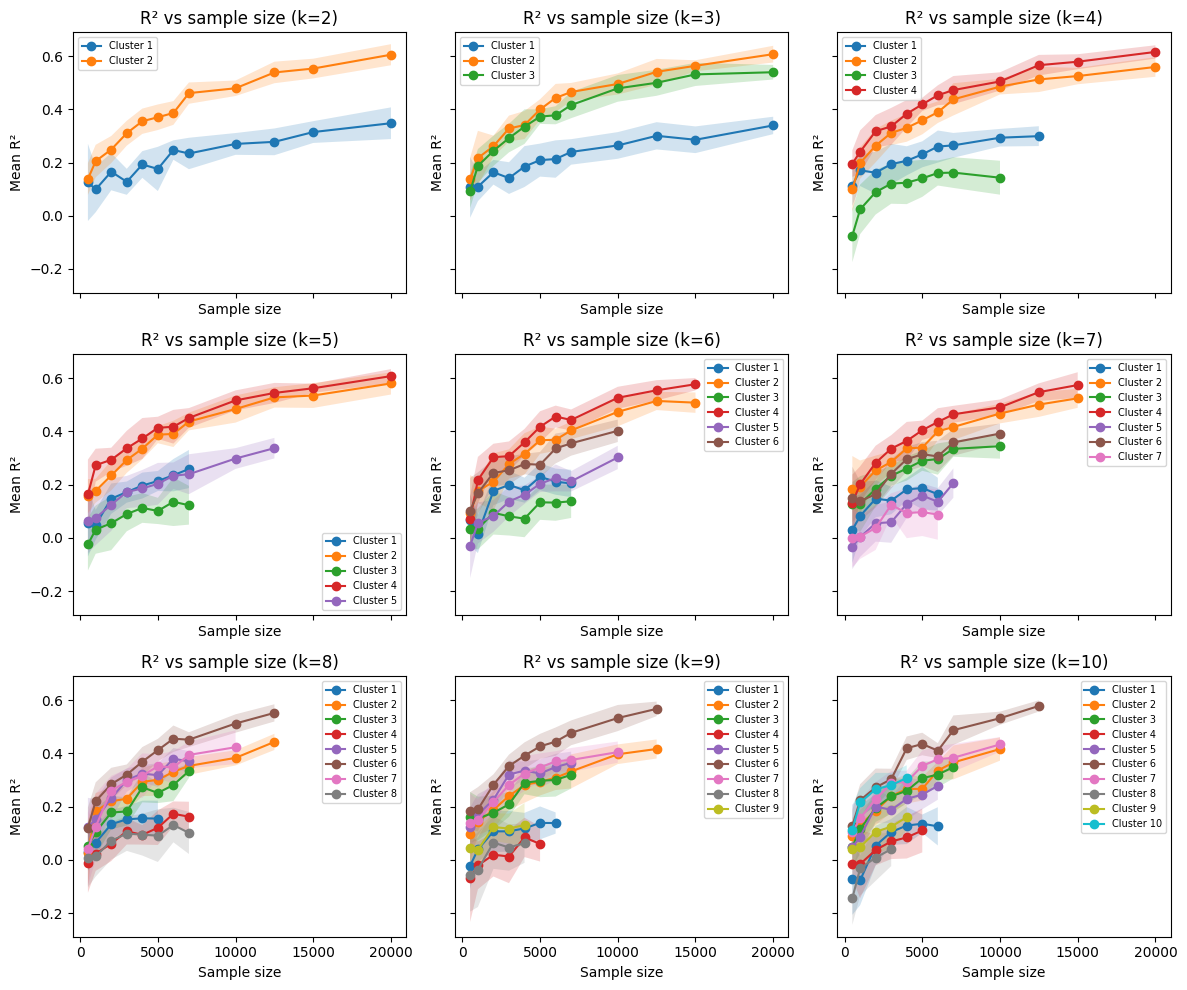

In [40]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(12, 10), sharex=True, sharey=True)
axs = axs.flatten()

for ax_num, k in enumerate(range(2, 11)):

    df_k = summary[summary["k"] == k]

    for cluster_num in sorted(df_k["cluster"].unique()):

        df_c = df_k[df_k["cluster"] == cluster_num]

        axs[ax_num].plot(
            df_c["sample_size"],
            df_c["mean_r2"],
            marker="o",
            label=f"Cluster {cluster_num}")
        
        axs[ax_num].fill_between(
        df_c["sample_size"],
        df_c["mean_r2"] - df_c["std_r2"],
        df_c["mean_r2"] + df_c["std_r2"],
        alpha=0.2)

    axs[ax_num].set_xlabel("Sample size")
    axs[ax_num].set_ylabel("Mean R²")
    axs[ax_num].set_title(f"R² vs sample size (k={k})")
    axs[ax_num].legend(fontsize=7)
    
fig.tight_layout()